### Stock Market Prediction And Forecasting Using Stacked LSTM

In [ ]:
### Keras and Tensorflow >2.0

In [ ]:
### Data Collection
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.3 MB 12.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=691e59b4f231a3b310063376a35e0632dbcccea3fc6a56792d428b7188aa414c
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
IBM = yf.Ticker('IBM')
IBM_hist=IBM.history(interval='1d',start='2015-01-01',end='2020-12-31')
IBM_hist.to_csv('IBM.csv')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df=pd.read_csv('IBM.csv',delimiter=',',usecols=['Date','Open','High','Low','Close'])

In [ ]:
df.head()

,Date,Open,High,Low,Close
0,2015-01-02,122.628159,124.148563,122.392499,123.198311
1,2015-01-05,122.597743,122.597743,121.016522,121.259781
2,2015-01-06,121.381403,121.601868,117.960495,118.644684
3,2015-01-07,119.503722,119.503722,117.093884,117.869293
4,2015-01-08,118.773918,120.902474,118.249377,120.431152


In [ ]:
df.tail()

,Date,Open,High,Low,Close
1505,2020-12-23,120.895646,122.193608,120.759020,120.915169
1506,2020-12-24,121.988664,122.086253,121.217695,121.686134
1507,2020-12-28,122.086257,123.550121,121.461676,121.813004
1508,2020-12-29,122.330236,122.457109,120.271067,120.817581
1509,2020-12-30,120.817582,121.842282,120.651672,121.344566


In [ ]:
df1=df.reset_index()['Close']

In [ ]:
df1.head()

0    123.198311
1    121.259781
2    118.644684
3    117.869293
4    120.431152
Name: Close, dtype: float64

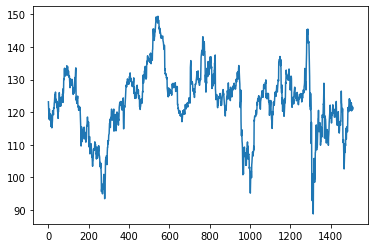

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
print(df1)

[[0.56718273]
 [0.53522275]
 [0.4921084 ]
 ...
 [0.54434357]
 [0.52793233]
 [0.53662058]]


In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
training_size,test_size

(1057, 453)

In [ ]:
train_data

array([[0.56718273],
       [0.53522275],
       [0.4921084 ],
       ...,
       [0.58092572],
       [0.58431999],
       [0.59376508]])

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   150 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 150
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(906, 150)
(906,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(302, 150)
(302,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(150,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

123.00273865323963

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

118.93612138588901

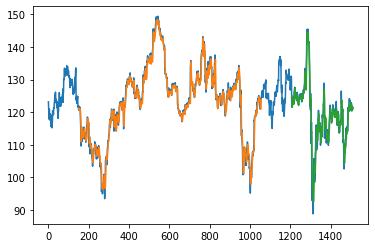

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=150
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

453

In [ ]:
x_input=test_data[302:].reshape(1,-1)
x_input.shape

(1, 151)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=150
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.49130628 0.49114968 0.50852631 0.55627289 0.55376803 0.60339306
 0.66115881 0.60041841 0.56910948 0.3834462  0.44449905 0.44042882
 0.49521978 0.47956538 0.47972186 0.45326554 0.43134913 0.40536261
 0.35855525 0.39941367 0.37060935 0.41068514 0.42665262 0.39174314
 0.40990239 0.41757318 0.37671464 0.37874969 0.34744064 0.3887686
 0.402075   0.42399141 0.4615626  0.47737373 0.49459363 0.51431864
 0.50946541 0.55032408 0.52934676 0.50523882 0.51181366 0.48457471
 0.49788124 0.45999723 0.46062325 0.48206999 0.50602145 0.49991617
 0.51040488 0.51785882 0.55195675 0.54624743 0.54545436 0.51896899
 0.52277532 0.50961182 0.51722437 0.50009616 0.48915299 0.4893116
 0.52927771 0.51278383 0.50532964 0.51294232 0.51960331 0.49169042
 0.49311794 0.56892659 0.50977043 0.47567251 0.45838543 0.47503805
 0.44807659 0.46235026 0.47234176 0.47789271 0.50612283 0.51722437
 0.48296783 0.44316033 0.44728377 0.42063966 0.40890354 0.42254289
 0.46663244 0.45410351 0.46568088 0.45648233 0.44823

In [ ]:
day_new=np.arange(1,151)
day_pred=np.arange(151,181)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

1510

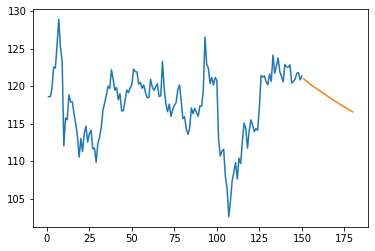

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1360:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

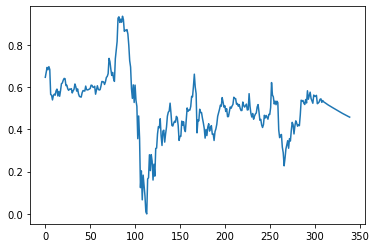

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

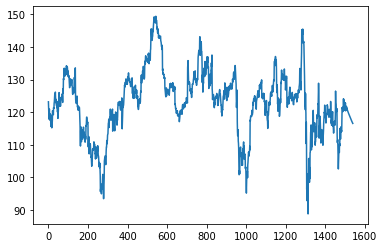

In [ ]:
plt.plot(df3)